In [1]:
import pandas as pd
pd.options.io.excel.xlsx.writer = 'xlsxwriter'

dataset = pd.read_csv(r'./datas/数字化差异性分析数据.csv', index_col=None, header=0, dtype={'股票代码':'object'})
js_dataset = dataset[dataset['上市省份']=='江苏']
print(js_dataset[js_dataset['digital']==1].shape[0])  # 只有236个数据是1，但是我们不提的话或许可以提高准确率。
# js_dataset.reset_index(inplace=True, drop=True)
# 删除不需要的数据
js_dataset = js_dataset.drop(['上市省份'], axis=1)
js_dataset

650


,股票代码,截止日期,企业年限,行业类别,权益乘数,速动比率,资本积累率B,固定资产增长率B,营业总收入增长率,销售费用增长率,...,股权性质,两权分离度(%),股权集中度4(%),独董比例,提供岗位增长率,员工收入增长率,研发强度,创新产出,董事会规模,digital
314,000301,2007,7.0,13.0,1.380405,0.668586,-0.006589,-0.273977,0.006221,0.041691,...,1,0.000000,40.2903,0.333333,0.263699,0.166207,2.003051,0.000000,2.302585,0
315,000301,2008,8.0,13.0,1.546510,0.492229,0.082254,-0.350255,-0.463183,-0.710069,...,1,0.000000,41.2454,0.333333,-0.394657,0.166207,2.003051,0.000000,2.302585,0
316,000301,2009,9.0,13.0,1.561810,0.724658,0.006033,-0.143850,-0.085466,0.813145,...,1,0.000000,43.7998,0.400000,0.069272,0.166207,2.003051,0.000000,2.397895,0
317,000301,2010,10.0,60.0,1.470518,1.270975,0.025920,-0.096754,0.233287,-0.668786,...,1,0.000000,41.7098,0.571429,0.028239,0.166207,2.003051,0.000000,2.079442,0
318,000301,2011,11.0,60.0,1.360832,1.019489,0.005543,-0.170452,0.170210,2.126254,...,1,0.000000,39.9150,0.384615,0.009693,0.166207,2.003051,0.000000,2.639057,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26718,870436,2022,1.0,32.0,1.778334,1.436806,-0.097942,-0.056501,-0.382923,-0.163350,...,0,16.988600,76.5233,0.333333,-0.030721,-0.114466,2.284421,4.234107,2.302585,0
26719,871396,2021,1.0,36.0,1.485790,2.525995,0.087010,-0.105547,-0.020185,-0.168257,...,0,5.108174,63.0868,0.250000,0.263699,0.166207,1.619388,2.708050,2.302585,1
26720,871396,2022,2.0,36.0,1.476032,2.110647,0.056330,0.182788,-0.087836,-0.070228,...,0,5.108174,63.0972,0.250000,0.010714,-0.048795,1.733424,3.496508,2.302585,1
26723,871642,2021,0.0,25.0,1.362160,1.854867,0.512965,0.379445,0.104335,0.105209,...,0,0.440000,71.3047,0.428571,0.263699,0.166207,2.512846,2.397895,2.079442,0


In [2]:
from sklearn.model_selection import train_test_split
from utils import normalize

head = ['股票代码','截止日期']
Xnames=['企业年限', '行业类别', '权益乘数', '速动比率', '资本积累率B', '固定资产增长率B', '营业总收入增长率', '销售费用增长率', '管理费用增长率', '现金资产比率', '全部现金回收率', '净利润现金净含量', '营运指数', '资本支出与折旧摊销比', '营业净利率', '销售期间费用率', '投入资本回报率（ROIC）', '成本费用利润率', '应付账款周转率B', '存货周转率B', '应收账款周转率B', '经营杠杆', '财务杠杆', '两职合一', '本期销售额占年度销售总额比例(%)', '本期采购额占年度采购总额比例(%)', '股权性质', '两权分离度(%)', '股权集中度4(%)', '独董比例', '提供岗位增长率', '员工收入增长率', '研发强度', '创新产出', '董事会规模']
Ynames=['digital']
headset = js_dataset[head]
# 对数据进行标准化，数据量有点大，可以尝试单纯拿出江苏省数据先进行分析
# 思路A:是不是可以进一步对全国数据通过行业筛选研究？

X = normalize(js_dataset[Xnames], method='m')
X = pd.DataFrame(X,columns=Xnames)
y = js_dataset[Ynames].values.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=1)

In [3]:
# 先进行决策树与逻辑回归的估计
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV

model = LogisticRegression(C=1e10, max_iter=500)
model.fit(X_train, y_train)
print(f'普通逻辑回归R2:{model.score(X_test, y_test)}')

model = DecisionTreeClassifier()
path = model.cost_complexity_pruning_path(X_train, y_train)
param_grid = {'ccp_alpha': path.ccp_alphas}
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
model = GridSearchCV(DecisionTreeClassifier(random_state=123), param_grid, cv=kfold)
model.fit(X_train, y_train)
print(f'十折交叉验证决策树最优准确率{model.score(X_test, y_test)}')

普通逻辑回归R2:0.8162650602409639
十折交叉验证决策树最优准确率0.8283132530120482


In [4]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=500, max_features='sqrt', random_state=132)
# 将特征变量个数的开平方作为参数max_features的取值，默认使用所有特征变量，等价于袋装法
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8524096385542169

In [5]:
# 十折交叉验证，寻找最优超参数
# 将y转化为bool变量
y_train_dummy = pd.get_dummies(y_train)
y_train_dummy = y_train_dummy.iloc[:, 1]

param_grid = {'max_features': range(1, 11) }
kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
model = GridSearchCV(RandomForestClassifier(n_estimators=500, random_state=123,n_jobs=-1), param_grid, cv=kfold)

model.fit(X_train, y_train_dummy)
print(model.best_params_, model.score(X_test, y_test))

{'max_features': 9} 0.8644578313253012


In [6]:
# 使用最优超参数再次进行随机森林的估计
model = RandomForestClassifier(n_estimators=500, max_features=9, random_state=123,n_jobs=-1)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8644578313253012

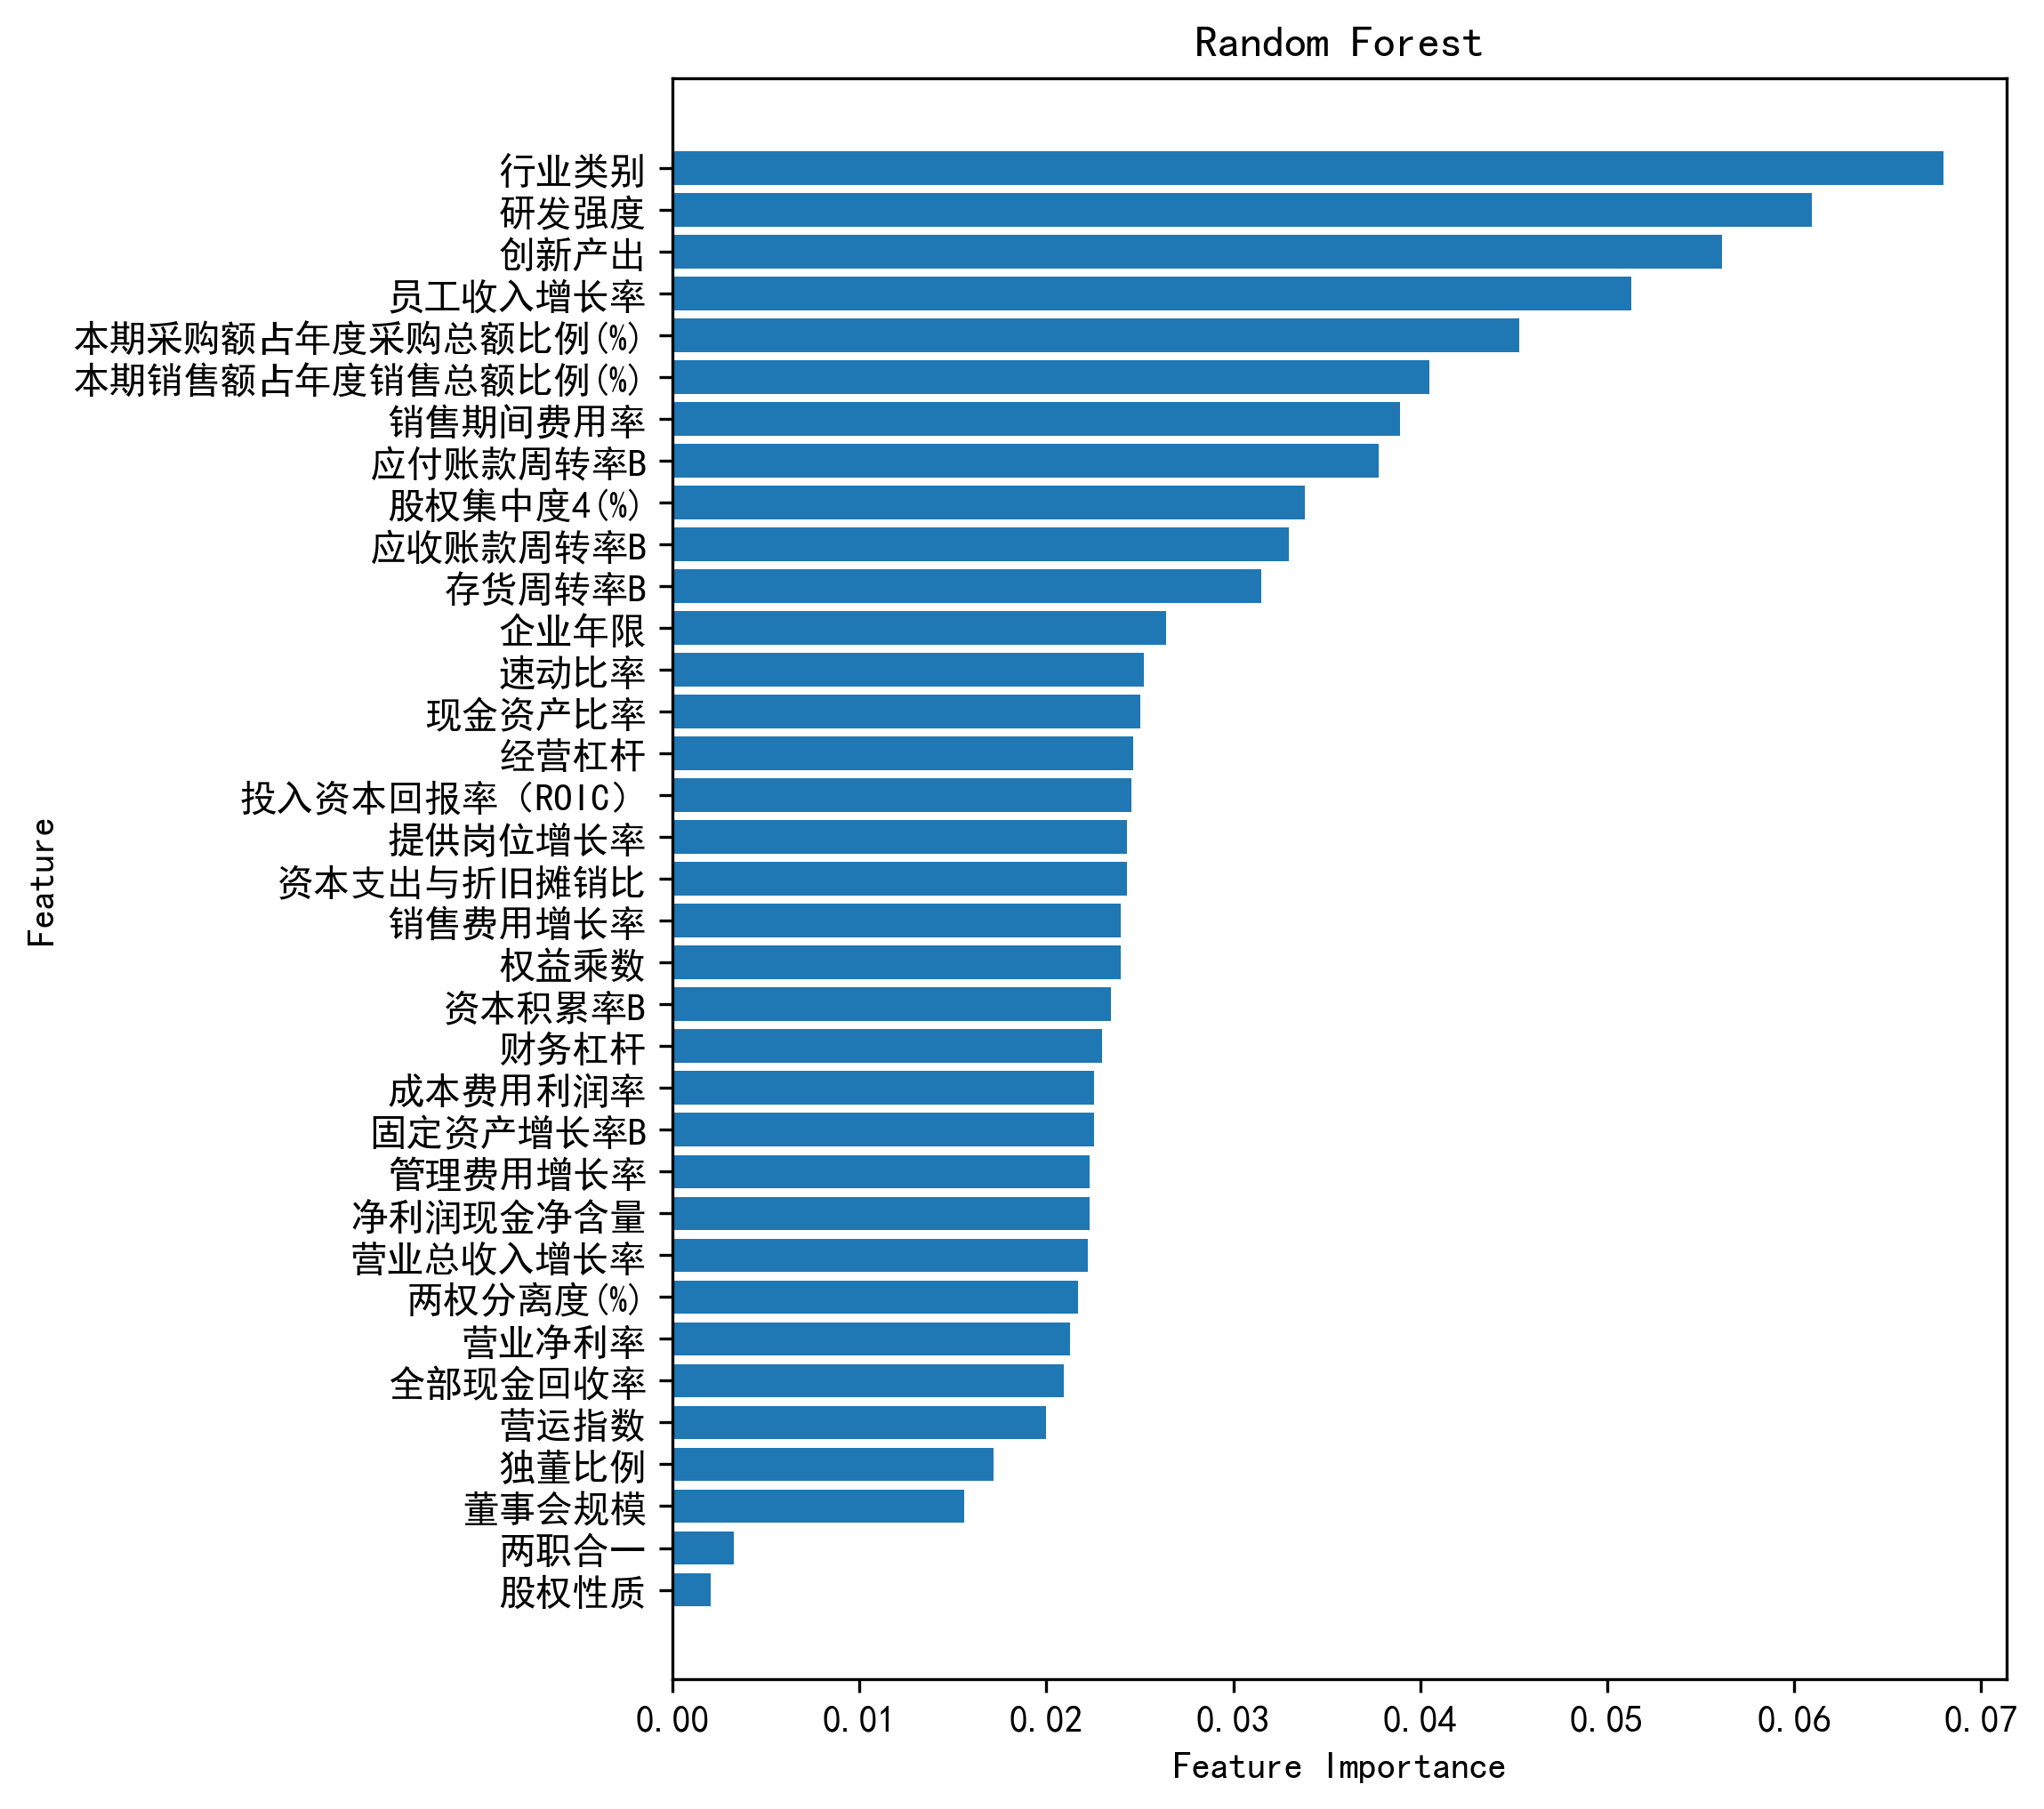

In [7]:
# 重要度分析
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False    # 用来正常显示负号

fig = plt.figure(figsize=(5, 6),dpi=300)
ax = fig.add_axes([0,0,1,1])

# model.feature_importances_
sorted_index = model.feature_importances_.argsort()
ax.barh(range(X.shape[1]), model.feature_importances_[sorted_index])
ax.set_yticks(np.arange(X.shape[1]), X.columns[sorted_index])
ax.set_xlabel('Feature Importance')
ax.set_ylabel('Feature')
ax.set_title('Random Forest')
plt.show()

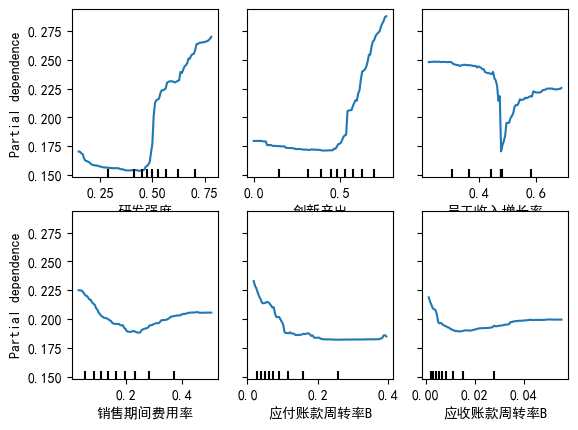

In [21]:
# 绘制关键变量的偏依赖图
from sklearn.inspection import PartialDependenceDisplay

disp1 = PartialDependenceDisplay.from_estimator(model, X_train, ['研发强度','创新产出','员工收入增长率','销售期间费用率','应付账款周转率B','应收账款周转率B'])
plt.show()

可见，响应变量（被解释变量）与研发强度、创新产出呈正相关，但非线性关系，与员工收入增长率、销售期间费用率呈弱负相关。

In [23]:
from sklearn.metrics import cohen_kappa_score

pred = model.predict(X_test)
table = pd.crosstab(y_test, pred, rownames=['Actual'], colnames=['Predicted'])
table = np.array(table)

Accuracy = (table[0, 0] + table[1, 1]) / np.sum(table)
Sensitivity  = table[1 , 1] / (table[1, 0] + table[1, 1])
Specificity = table[0, 0] / (table[0, 0] + table[0, 1])
Recall = table[1, 1] / (table[0, 1] + table[1, 1])

print(f"准确率Accuracy:{Accuracy}")
print(f"灵敏度Sensitivity:{Sensitivity}")
print(f"特异度Specificity:{Specificity}")
print(f"召回率Recall:{Recall}")
print(f'科恩kappa系数：{cohen_kappa_score(y_test, pred)}，预测值与实际值之间具有较好的一致性。')

准确率Accuracy:0.8644578313253012
灵敏度Sensitivity:0.3230769230769231
特异度Specificity:0.9962546816479401
召回率Recall:0.9545454545454546
科恩kappa系数：0.42591454042422383，预测值与实际值之间具有较好的一致性。


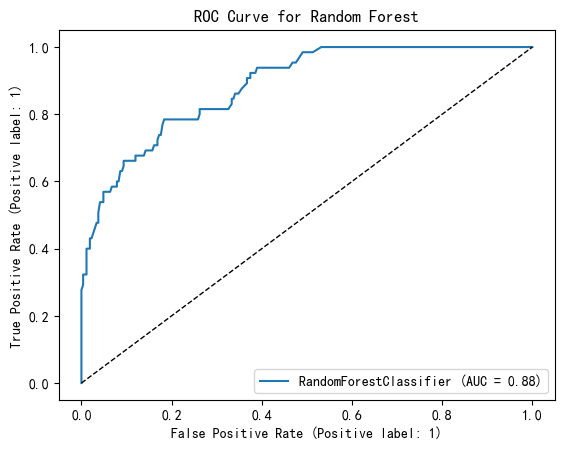

In [24]:
from sklearn.metrics import RocCurveDisplay

s = RocCurveDisplay.from_estimator(model, X_test, y_test)
x = np.linspace(0, 1, 100)
plt.plot(x, x, 'k--', linewidth=1)
plt.title('ROC Curve for Random Forest')
plt.show()

0.976491862567812


C:\Envs\digital\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


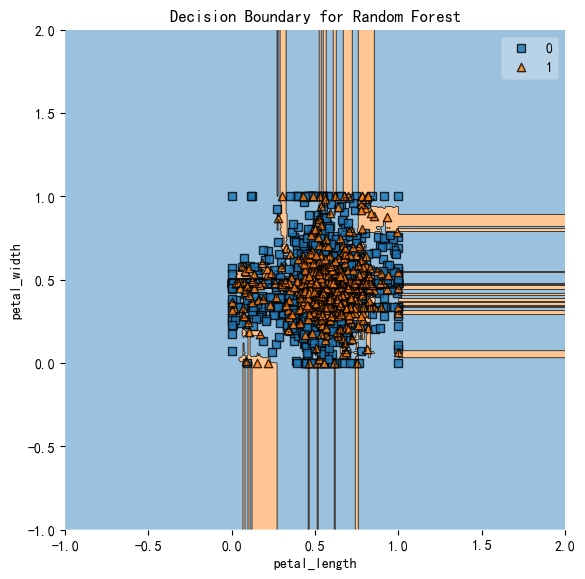